In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
np.random.seed(1)

sns.set_style("whitegrid")

In [2]:
def generate_data(num_samples=100):
    # Parameters for first Gaussian blob
    mean1 = [2.0, 3.0]
    cov1 = [[1.0, 0.3], [0.3, 0.5]]

    # Parameters for second Gaussian blob
    mean2 = [-1.0, -2.0]
    cov2 = [[0.4, -0.1], [-0.1, 0.3]]

    # Parameters for third Gaussian blob
    mean3 = [4.0, -1.0]
    cov3 = [[0.3, 0.2], [0.2, 0.5]]

    # Parameters for fourth Gaussian blob
    mean4 = [-3.0, 2.0]
    cov4 = [[0.5, -0.2], [-0.2, 0.3]]

    # Generate data points
    data1 = np.random.multivariate_normal(mean1, cov1, num_samples // 4)
    data2 = np.random.multivariate_normal(mean2, cov2, num_samples // 4)
    data3 = np.random.multivariate_normal(mean3, cov3, num_samples // 4)
    data4 = np.random.multivariate_normal(mean4, cov4, num_samples // 4)
    data = np.vstack([data1, data2, data3, data4])
    #data = (data - data.min()) / (data.max() - data.min()) * 10 - 5

    return torch.tensor(data, dtype=torch.float32)

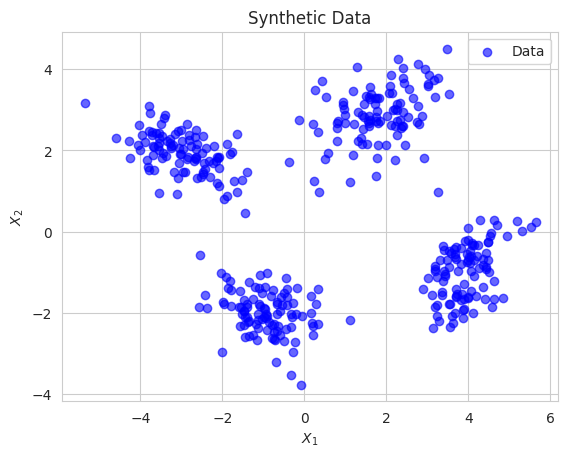

In [3]:
num_datasamples = 400
data = generate_data(num_datasamples)

plt.title("Synthetic Data")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, color="blue", label = "Data")
plt.legend()
plt.show()

In [4]:
from simple_einet.einet import Einet, EinetConfig
from simple_einet.layers.distributions.normal import Normal

cfg = EinetConfig(
    num_features=2,
    num_channels=1,
    num_sums=4,
    num_leaves=4,
    num_repetitions=4,
    num_classes=1,
    depth=1,
    dropout=0.0,
    leaf_type=Normal,
    layer_type="einsum"
)

model = Einet(cfg)
print(model)

Einet(
  EinetConfig(num_features=2, num_channels=1, num_sums=4, num_leaves=4, num_repetitions=4, num_classes=1, depth=1, dropout=0.0, leaf_type=<class 'simple_einet.layers.distributions.normal.Normal'>, leaf_kwargs={}, layer_type='einsum')
  (leaf): FactorizedLeaf(
    num_features=2, num_features_out=2
    (base_leaf): Normal(num_features=2, num_leaves=4, out_shape=(N, 2, 4))
  )
  (layers): ModuleList(
    (0): EinsumLayer(num_features=2, num_sums_in=4, num_sums_out=1, out_shape=(N, 1, 1, 4), weight_shape=(1, 1, 4, 4, 4))
  )
  (mixing): MixingLayer(num_features=1, num_sums_in=4, num_sums_out=1)
)


In [5]:
from tqdm import tqdm

def train(data, model, epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    loss_log = []

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        log_prob = model(data)
        loss = -torch.mean(log_prob)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())

    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(epochs), loss_log)
    plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 434.22it/s]


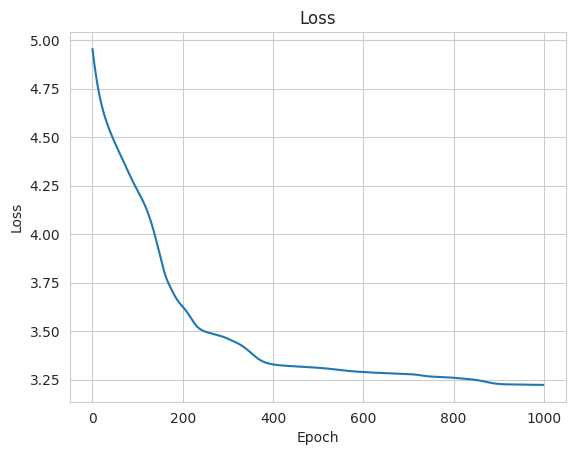

In [6]:
train(data, model, 1000)

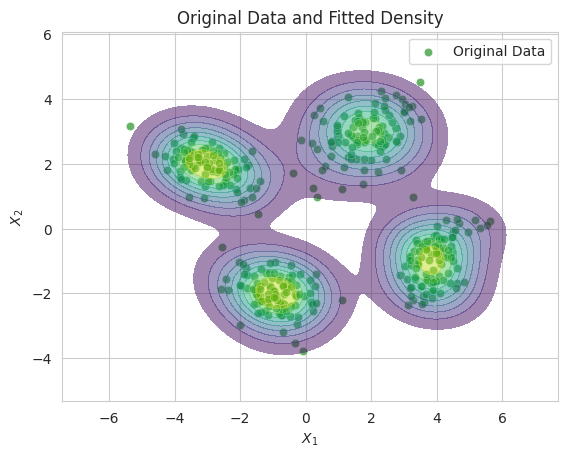

In [7]:
def plot_data_and_distribution_seaborn(data, model):
    # Generate a grid over which we evaluate the model's density function
    x, y = np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(
        data[:, 1].min(), data[:, 1].max(), 100
    )
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Evaluate the learned density function over the grid
    with torch.no_grad():
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        log_prob = model(grid_tensor)
        prob_density = log_prob.exp().numpy().ravel()  # Ensure this is 1-dimensional

    # Plot for original data points using Seaborn
    sns.scatterplot(x=data[:, 0], y=data[:, 1], color="green", alpha=0.6, label="Original Data")
    sns.kdeplot(x=grid[:, 0], y=grid[:, 1], weights=prob_density, fill=True, cmap="viridis", alpha=0.5)
    plt.title("Original Data and Fitted Density")
    plt.legend()
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.show()

plot_data_and_distribution_seaborn(data, model)

In [8]:
def generate_query():
    l1, l2, u1, u2 = np.random.rand(4) * 8 - 4
    if l1 > u1:
        l1, u1 = u1, l1
    if l2 > u2:
        l2, u2 = u2, l2 
    return torch.Tensor([[l1, u1], [l2, u2]])

def calc_qerr(est, GT, epsilon = 10):
    if GT < epsilon:
        GT = epsilon
    if est < epsilon:
        est = epsilon
    return max(GT / est, est / GT)

def perform_query(points, query):
    ll, ur = query.squeeze().unbind(-1)
    l1, l2 = ll.tolist()
    u1, u2 = ur.tolist()
    cnt = 0
    for pt in points:
        if l1 <= pt[0] and pt[0] <= u1 and l2 <= pt[1] and pt[1] <= u2:
            cnt += 1
    if cnt < 10:
        cnt = 10
    return cnt

def experiment_counting(data, model: Einet, n_runs, epsilon = 10):
    gmq = 0
    for i in tqdm(range(n_runs)):
        while True:
            query = generate_query()
            GT = perform_query(data, query)
            if (GT > 10):
                break
        est = model.integrate(query).item() * len(data)
        q_err = calc_qerr(est, GT, epsilon)
        gmq += np.log(q_err)
    return np.exp(gmq / n_runs)

In [9]:
experiment_counting(data, model, 500)

100%|██████████| 500/500 [00:06<00:00, 81.81it/s] 


1.0715474874612405

In [10]:
x = torch.tensor([[[0.5, 0.5]]])
model(x)

tensor([[-6.8865]], grad_fn=<SqueezeBackward1>)

<Axes: ylabel='Count'>

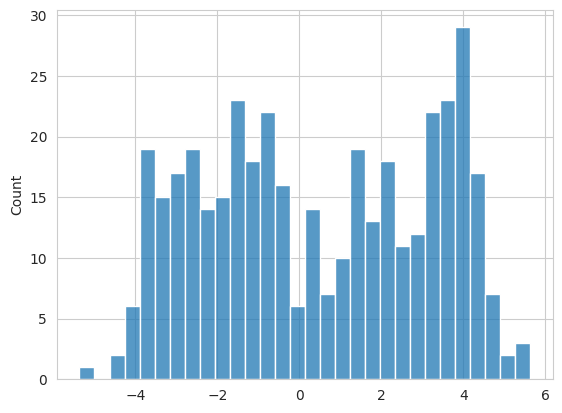

In [11]:
sns.histplot(data=data[:, 0], bins=30)

In [12]:
d = model.leaf.base_leaf._get_base_distribution()
params = []
N = cfg.num_leaves
R = cfg.num_repetitions
neginf = np.finfo(np.float32).min

for i in range(N):
    X2 = torch.full((1, N, R), 0)
    for j in range(R):
        X1 = torch.full((1, N, R), neginf)
        X1[0][i][j] = 0
        X = torch.vstack([X1, X2]).unsqueeze(0).unsqueeze(0)
        w = model.forward(X, skip_leaf=True).exp().item()
        n = d.loc[0][0][0][i][j].item()
        s = d.scale[0][0][0][i][j].item()
        params.append((w, n, s))

params

[(0.0014961567940190434, 0.8841013312339783, 1.698015809059143),
 (0.0001446351525373757, 0.6269052624702454, 3.0969250202178955),
 (0.09708428382873535, -2.1458661556243896, 0.39752012491226196),
 (0.16823099553585052, -3.318662405014038, 0.501957356929779),
 (0.001747588743455708, 0.40004608035087585, 0.8519952297210693),
 (0.025573838502168655, 4.869120121002197, 0.49263590574264526),
 (0.22107914090156555, 3.827704429626465, 0.43646934628486633),
 (0.22490394115447998, 1.9205602407455444, 0.7387814521789551),
 (0.22447988390922546, -0.8468789458274841, 0.5809371471405029),
 (0.00021525351621676236, -0.9895983934402466, 1.185080647468567),
 (0.001444036839529872, 0.1277177780866623, 1.493536353111267),
 (0.00731424055993557, -2.6355807781219482, 2.5533688068389893),
 (0.000689975218847394, 0.5609086751937866, 2.005507230758667),
 (0.0063136275857687, 1.5157663822174072, 1.8987736701965332),
 (0.0011569780763238668, 1.3862403631210327, 2.1662585735321045),
 (0.018125437200069427, 0.4

In [13]:
params2 = []

for i in range(N):
    X2 = torch.full((1, N, R), 0)
    for j in range(R):
        X1 = torch.full((1, N, R), neginf)
        X1[0][i][j] = 0
        X = torch.vstack([X2, X1]).unsqueeze(0).unsqueeze(0)
        w = model.forward(X, skip_leaf=True).exp().item()
        n = d.loc[0][0][1][i][j].item()
        s = d.scale[0][0][1][i][j].item()
        params2.append((w, n, s))

params2

[(0.0007845463114790618, -0.013638925738632679, 1.6924161911010742),
 (0.006099233403801918, 1.1675500869750977, 0.4053518772125244),
 (0.012058690190315247, -1.1776199340820312, 0.39523032307624817),
 (0.21529936790466309, 3.053985834121704, 0.5588467121124268),
 (0.025478946045041084, -2.6471669673919678, 0.6746848821640015),
 (0.025311987847089767, 0.10186245292425156, 0.15525437891483307),
 (0.07717405259609222, 1.5586377382278442, 0.43162035942077637),
 (0.0015141430776566267, 1.1982592344284058, 1.4102567434310913),
 (0.000613390002399683, 0.28194430470466614, 1.9230026006698608),
 (0.0006073044496588409, 0.9510324001312256, 0.4630715250968933),
 (0.10593301057815552, -1.718418002128601, 0.31405574083328247),
 (0.005193539895117283, 1.7449133396148682, 0.7482490539550781),
 (0.20153670012950897, -1.9830560684204102, 0.43132486939430237),
 (0.00022883152996655554, -1.7235900163650513, 0.6776991486549377),
 (0.1255986988544464, -0.6676576137542725, 0.28876158595085144),
 (0.1965675

In [14]:
from scipy.stats import norm

def func(params, x):
    ans = 0
    for param in params:
        w, n, s = param
        ans += w * norm.pdf(x=x, loc=n, scale=s)
    return ans

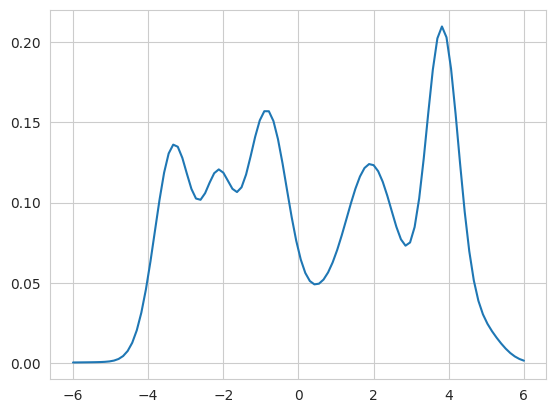

In [15]:
def funcplot(func, range, label=None):
    lb, ub = range
    x = np.linspace(lb, ub, 100, dtype=np.float32)
    y = []
    for it in x:
        y.append(func(it))
    if label is not None:
        plt.plot(x, y, label=label)
    else:
        plt.plot(x, y)

funcplot(lambda x : func(params, x), (-6, 6))

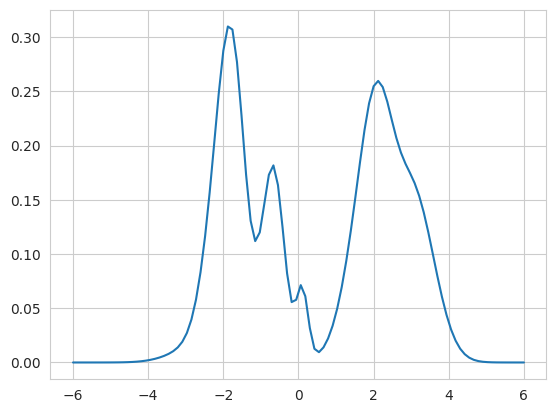

In [16]:
funcplot(lambda x : func(params2, x), (-6, 6))

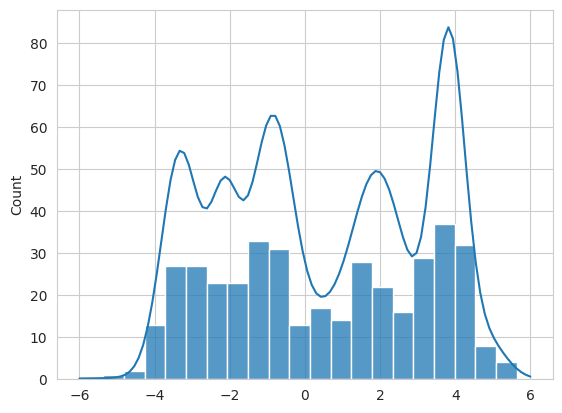

In [17]:
plt.figure()
sns.histplot(data=data[:, 0], bins=20)
funcplot(lambda x : func(params, x) * num_datasamples, (-6, 6))
plt.show()

In [18]:
model.forward(torch.tensor([[[0, 0]]]), marginalized_scopes=torch.tensor([1])).exp().item()

0.07004455476999283

In [19]:
def func2(x):
    #x = torch.float(x)
    return model.forward(torch.tensor([[[x, 0]]]), marginalized_scopes=torch.tensor([1])).exp().item()

func2(0)

0.07004455476999283

In [20]:
def func3(x):
    #x = torch.float(x)
    return model.forward(torch.tensor([[[0, x]]]), marginalized_scopes=torch.tensor([0])).exp().item()

func2(0)

0.07004455476999283

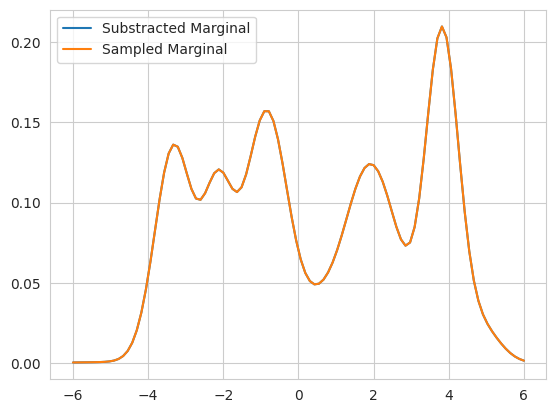

In [21]:
plt.figure()
funcplot(lambda x : func(params, x), (-6, 6), label="Substracted Marginal")
funcplot(func2, (-6, 6), label="Sampled Marginal")
plt.legend()
plt.show()

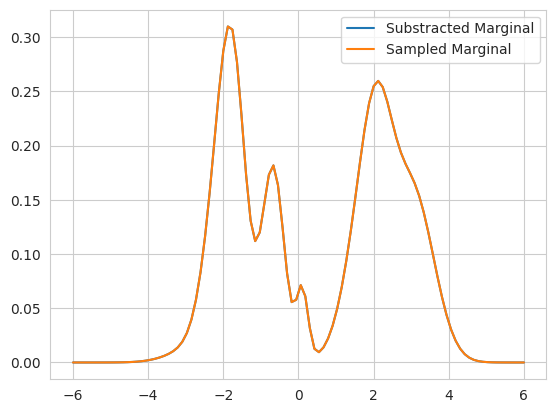

In [22]:
plt.figure()
funcplot(lambda x : func(params2, x), (-6, 6), label="Substracted Marginal")
funcplot(func3, (-6, 6), label="Sampled Marginal")
plt.legend()
plt.show()

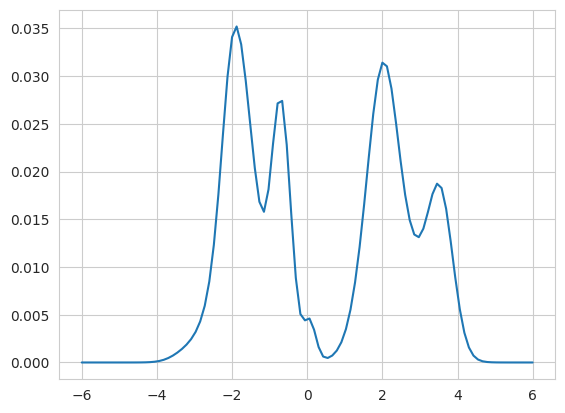

In [23]:
def mergeFunc1(x):
    return func2(x) * func3(x)

funcplot(mergeFunc1, (-6, 6))

In [24]:
params3 = []

for pi in params:
    for pj in params2:
        w1, n1, s1 = pi
        w2, n2, s2 = pj
        s12 = s1 ** 2
        s22 = s2 ** 2
        t = s12 + s22
        n = (n2 * s12 + n1 * s22) / t
        s = np.sqrt(s12 * s22 / t)
        w = w1 * w2 * np.exp(-((n1 - n2) ** 2) / (2 * t)) / np.sqrt(2 * np.pi * t)
        params3.append((w, n, s))


params3

[(1.8210255010323188e-07, 0.43374850415588545, 1.1986938245903698),
 (2.0580744115139392e-06, 1.1522678985090336, 0.3942731726074168),
 (2.0516728702287076e-06, -1.07166202933189, 0.3849403483977898),
 (3.441183336352333e-05, 2.841918368981682, 0.5308360915761545),
 (1.2858908395619955e-06, -2.1656774488507837, 0.6270032475711158),
 (7.97557536340973e-06, 0.10834772292922863, 0.15460945944993626),
 (2.4413675175599726e-05, 1.5176990440129243, 0.41831749194223616),
 (4.0531995955455204e-07, 1.0700173795055774, 1.0848823160223118),
 (1.388377726520243e-07, 0.6202930972921207, 1.2728263738620498),
 (2.0580713446890044e-07, 0.9463991521004663, 0.4467562366037478),
 (1.1760919109815158e-05, -1.6323352766295145, 0.30881810350389566),
 (1.5001731288392468e-06, 1.6049395558759008, 0.6847167030157714),
 (1.7994095242702974e-05, -1.8092674381559788, 0.41804847341059825),
 (2.7014726123246377e-08, -1.3652838721848362, 0.6294203267301456),
 (2.900589588221069e-05, -0.6240423896432785, 0.2846745578

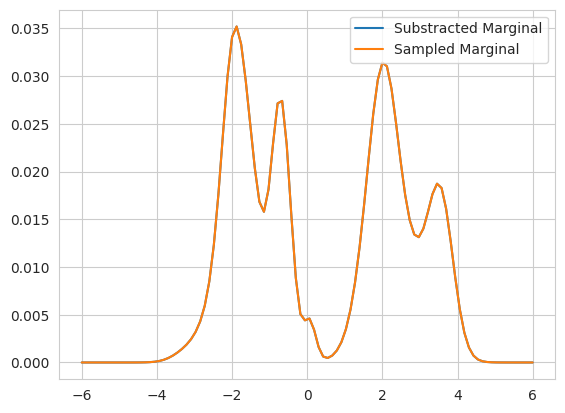

In [25]:
plt.figure()
funcplot(lambda x : func(params3, x), (-6, 6), label="Substracted Marginal")
funcplot(mergeFunc1, (-6, 6), label="Sampled Marginal")
plt.legend()
plt.show()

In [26]:
loc = d.loc.squeeze()
scale = d.scale.squeeze()

In [27]:
from torch.distributions import Normal as Norm 

norm1 = Norm(loc=loc[0], scale=scale[0])
norm1

Normal(loc: torch.Size([4, 4]), scale: torch.Size([4, 4]))

In [28]:
xx = norm1.log_prob(torch.tensor([0], requires_grad=False)).unsqueeze(0)
xx.shape

torch.Size([1, 4, 4])

In [29]:
xxx = norm1.log_prob(torch.tensor([1], requires_grad=False)).unsqueeze(0)
xxx = torch.vstack([xx, xxx])
xxx.shape

torch.Size([2, 4, 4])

In [30]:
xxx[1]

tensor([[ -1.4507,  -2.0566, -31.3100, -37.2410],
        [ -1.0067, -31.0529, -21.0759,  -1.3925],
        [ -5.4293,  -2.4981,  -1.4906,  -2.8700],
        [ -1.6388,  -1.5970,  -1.7078,  -0.7955]], grad_fn=<SelectBackward0>)

In [31]:
query = [0.5, None, (0.5, 0.9)]
for it in query:
    if it is None:
        print("None")
    elif type(it) is float:
        print(f"Float of {it}")
    elif type(it) is tuple:
        a, b = it
        print(f"Tuple of ({a}, {b})")
    else:
        print("Error")

Float of 0.5
None
Tuple of (0.5, 0.9)


In [35]:
x = model.query_per_leaf([(-1.0, 4.0), None])
x

tensor([[[-1.8253e-01, -5.7575e-01, -6.2285e+00, -1.3170e+01],
         [-5.1480e-02, -3.2481e+00, -4.2543e-01, -2.4829e-03],
         [-5.0427e-01, -6.8619e-01, -2.6119e-01, -1.3617e+00],
         [-3.0297e-01, -2.0822e-01, -2.8652e-01, -5.8680e-04]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<CatBackward0>)

In [36]:
model.integrate(torch.tensor([[[-1, 4], [-10, 10]]]))

tensor([[0.5363]], grad_fn=<ExpBackward0>)

In [37]:
model.forward(x.unsqueeze(0).unsqueeze(0), skip_leaf=True).exp()

tensor([[0.5363]], grad_fn=<ExpBackward0>)